# ISIC

## Setup

In [ ]:
#Downloading Isic dataset from drive itself here for faster loading
%cd /content
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zWUzBpGEDtxTmUbNtyziheNjGs2LHQSO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zWUzBpGEDtxTmUbNtyziheNjGs2LHQSO" -O isic-data.zip && rm -rf /tmp/cookies.txt
!unzip -q isic-data.zip -d ./

In [ ]:
%matplotlib inline
from importlib import reload
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
import os
sys.path.append('/content/drive/My Drive/code/src')
import models_r
import isic_gen
import numpy as np
# print(tf.test.is_tpu_available())

/content/drive/My Drive/code


## Develop

In [ ]:
%cd /content/drive/My\ Drive/code/src

/content/drive/My Drive/code


In [ ]:
%%writefile isic_gen.py
import tensorflow as tf
from PIL import Image
import numpy as np
import random
import os
import pickle
from tqdm import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.test.is_gpu_available())

absp = lambda x : os.path.abspath(x) 

abs_train_img = './isic-challenge-2017/ISIC-2017_Training_Data'
abs_train_mask = './isic-challenge-2017/ISIC-2017_Training_GroundTruth'

abs_test_img = './isic-challenge-2017/ISIC-2017_Test_Data'
abs_test_mask = './isic-challenge-2017/ISIC-2017_Test_GroundTruth'

abs_val_img = './isic-challenge-2017/ISIC-2017_Validation_Data'
abs_val_mask = './isic-challenge-2017/ISIC-2017_Validation_GroundTruth'

def find_mean(img_path):
    imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
    mean = np.zeros((256,256,3))
    for i in tqdm(imgs):
        imgs_np = np.asarray(Image.open(i)) / 255.
        mean = mean + imgs_np
    
    mean = mean / len(imgs)

    return mean

def find_std_dev(img_path, mean):
    imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
    err = np.zeros((256,256,3))
    for i in imgs:
        imgs_np = np.asarray(Image.open(i)) / 255.
        err = err + np.square(imgs_np - mean)

    err = err / len(imgs)
    return np.sqrt(err)

def data_gen(img_path = abs_train_img, mask_path = abs_train_mask, batch_size = 1, random_state = 7, center = False, norm = False, mean = None, std_dev = None, sample_wise_normalize = False):
    imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
    masks = sorted([absp(os.path.join(mask_path, i)) for i in os.listdir(mask_path) if not i.startswith('.')])
    
    if norm: center = True
    if center: 
        if (mean is None): mean = find_mean(img_path)

    if norm:
        if (std_dev is None): std_dev = find_std_dev(img_path, mean)

    if len(imgs) != len(masks):
        print("img-mask mismatch")
        return

    data = [(i,j) for i,j in zip(imgs, masks)]
    
    random.seed(random_state)
    random.shuffle(data)
    
    n = len(data)
    imgs_np = np.zeros((batch_size, 256, 256, 3))
    masks_np = np.zeros((batch_size,256,256))
    
    i = 0

    while True:
        for c in range(batch_size):
            imgs_np[c] = np.asarray(Image.open(data[i][0])) / 255.
            if sample_wise_normalize : imgs_np[c] = tf.image.per_image_standardization(imgs_np[c])
            masks_np[c] = np.asarray(Image.open(data[i][1])) / 255.
            i+=1
            i%=n 
        if center: imgs_np = imgs_np - mean
        if norm: imgs_np = imgs_np / std_dev
        yield imgs_np, masks_np

#################### Pure Tensorflow Data-Generators Tensorflow ##########################

def find_mean_tf(img_path = abs_train_img):
    imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
    mean = tf.zeros((256,256,3))
    for i in tqdm(imgs):
        mean = mean + get_img(i)
    mean = mean / len(imgs)
    return mean

def find_std_dev_tf(img_path = abs_train_img, mean = None):
    if mean is None:
        return
    std_dev = tf.zeros((256,256,3))
    imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
    for i in tqdm(imgs):
        std_dev = std_dev + tf.square(get_img(i) - mean)
    std_dev = std_dev / len(imgs)
    return tf.sqrt(std_dev)

def get_mask(mask_pth):
    mask = tf.io.read_file(mask_pth)
    mask = tf.reshape(tf.io.decode_image(mask, dtype = tf.dtypes.float32), (256,256))
    return mask

def get_img(img_path, mean = None, std_dev = None):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, dtype = tf.dtypes.float32)
    if mean is None: return img
    img = img - mean
    if std_dev is None: return img
    img = img / std_dev
    return img

def process(file_ds, mean = None, std_dev = None):
    return tf.reshape(get_img(file_ds[0], mean, std_dev),(256,256,3)), tf.reshape(get_mask(file_ds[1]), (256,256))

def tf_dataset(img_path = abs_train_img, mask_path = abs_train_mask, batch_size = 10, cache = False, random_state = 7, center = False, mean = None, std_dev = None):
    
    imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
    masks = sorted([absp(os.path.join(mask_path, i)) for i in os.listdir(mask_path) if not i.startswith('.')])
    random.seed(random_state)

    data = [(i,j) for i,j in zip(imgs, masks)]

    if center:
        if mean is None: mean = find_mean_tf()
        if std_dev is None: std_dev = find_std_dev_tf(abs_train_img, mean)
    else:
        mean = None
        std_dev = None

    random.shuffle(data)
    list_ds = tf.data.Dataset.from_tensor_slices(data)
    ds = list_ds.map(lambda x : process(x , mean, std_dev), num_parallel_calls = AUTOTUNE)
    if type(cache) == str:
        ds = ds.cache(cache)
    elif cache:
        ds = ds.cache()
    
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds

Overwriting isic_gen.py


### Test

In [ ]:
import models_r
import isic_gen
import callbacks

In [ ]:
reload(models_r)
reload(isic_gen)
reload(callbacks)

True


<module 'callbacks' from '/content/drive/My Drive/code/callbacks.py'>

# RBV

## Setup

In [ ]:
#Download RBV Dataset for faster loading
# https://drive.google.com/file/d/1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG/view?usp=sharing
%cd /content
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG" -O rbv.zip && rm -rf /tmp/cookies.txt
!unzip -q rbv.zip -d ./

/content
--2020-06-25 17:22:46--  https://docs.google.com/uc?export=download&confirm=x4JZ&id=1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG
Resolving docs.google.com (docs.google.com)... 172.217.204.113, 172.217.204.100, 172.217.204.101, ...
Connecting to docs.google.com (docs.google.com)|172.217.204.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/74qlln96vcggcevj8mprhmakuo0ssdiu/tmvs2qk3585sgd4q5m18f5f2mhiihkgq/1593105750000/02906136874550114041/17031405717476856086Z/1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG?e=download [following]
--2020-06-25 17:22:47--  https://doc-0g-0k-docs.googleusercontent.com/docs/securesc/74qlln96vcggcevj8mprhmakuo0ssdiu/tmvs2qk3585sgd4q5m18f5f2mhiihkgq/1593105750000/02906136874550114041/17031405717476856086Z/1-9thgD6QrA9eqA2ZBSf_yHkaHPEoRGVG?e=download
Resolving doc-0g-0k-docs.googleusercontent.com (doc-0g-0k-docs.googleusercontent.com)... 64.233.170.132, 2607:f8b0:400c:c0d::

In [ ]:
#Settings
%matplotlib inline
import matplotlib.pyplot as plt

from importlib import reload
import sys
import os
sys.path.append('/content/drive/My Drive/code/src')

import tensorflow as tf
import numpy as np
import callbacks

%cd /content/drive/My\ Drive/code

/content/drive/My Drive/code


## Develop


In [ ]:
%cd /content/drive/My\ Drive/code/src

/content/drive/My Drive/code


In [ ]:
%%writefile rbv_gen.py

import tensorflow as tf
from PIL import Image
import numpy as np
import random
import os
import pickle
from tqdm import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE
print(tf.test.is_gpu_available())

absp = lambda x : os.path.abspath(x) 
absjoin = lambda x, y : absp(os.path.join(x,y))
abs_train_img = './rbv/patches128/'
abs_train_mask  = './rbv/patches128/'

def find_mean_tf(img_path, shape):
    if type(img_path) == str: imgs = sorted([absjoin(img_path, i) for i in os.listdir(img_path)])
    else: imgs = img_path
    mean = tf.zeros(shape)
    for i in tqdm(imgs):
        mean = mean + get_patch(i)
    mean = mean / len(imgs)
    return mean

def find_std_dev_tf(img_path, shape, mean):
    if type(img_path) == str : sorted([absjoin(img_path, i) for i in os.listdir(img_path)])
    else: imgs = img_path

    std_dev = tf.zeros(shape)

    for i in tqdm(imgs):
        std_dev = std_dev + tf.square(get_patch(i, False, mean))
    std_dev = std_dev / len(imgs)
    return tf.sqrt(std_dev)

def get_patch(pth, img_wise_norm= False, mean = None, std_dev = None):
    img = tf.io.read_file(pth)
    img = tf.io.decode_image(img, dtype = tf.dtypes.float32)
    if not (mean is None): img = img - mean
    if not (std_dev is None): img = img / std_dev
    if img_wise_norm: img = tf.image.per_image_standardization(img)
    return img

def process_training_data(data_point, shape, img_wise_norm = False, mean = None, std_dev = None):
    return tf.reshape(get_patch(data_point[0], img_wise_norm, mean, std_dev), shape) , tf.reshape(get_patch(data_point[1], False, None, None), (shape[0], shape[1]))

def tf_dataset(img_path = abs_train_img + 'patch_img', mask_path = abs_train_mask + 'patch_gt', batch_trn = 1, batch_val = 1, shape = (128,128,3), split = 0.8, cache = False, random_state = 7, img_wise_norm = False, center = False, mean = None, std_dev = None):
    
    random.seed(random_state)
    imgs = sorted([absjoin(img_path, i) for i in os.listdir(img_path)])
    masks = sorted([absjoin(mask_path, i) for i in os.listdir(mask_path)])

    data = [(i,j) for i,j in  zip(imgs, masks)]
    random.shuffle(data)
    
    n = len(data)
    n_train = int(n*split)
    n_val = n - n_train

    data_train = data[:n_train]
    data_val = data[n_train:]

    list_ds_trn = tf.data.Dataset.from_tensor_slices(data_train)
    list_ds_val = tf.data.Dataset.from_tensor_slices(data_val)

    if img_wise_norm:
        center = False
        mean = None
        std_dev = None

    if center:
        if (mean is None): mean = find_mean_tf([i for i,j in data_train], shape)
        if (std_dev is None): std_dev = find_std_dev_tf([i for i,j in data_train], shape, mean)

    ds_trn = list_ds_trn.map(lambda x : process_training_data(x , shape, img_wise_norm, mean, std_dev), num_parallel_calls = AUTOTUNE)
    ds_val = list_ds_val.map(lambda x : process_training_data(x , shape, img_wise_norm, mean, std_dev), num_parallel_calls = AUTOTUNE)
    
    if type(cache) == str:
        ds_trn, ds_val = ds_trn.cache(cache + 'trn'), ds_val.cache(cache + 'val')
    elif cache:
        ds_trn = ds_trn.cache()

    ds_trn, ds_val = ds_trn.repeat().batch(batch_trn).prefetch(buffer_size = AUTOTUNE), ds_val.repeat().batch(batch_val).prefetch(buffer_size = AUTOTUNE)
    
    return ds_trn, ds_val

def tf_dataset_real_time(data_path, batch_trn = 1, batch_val = 1, shape = (64,64,3), split = 0.8, random_state = 7, center = False, ret_norm_factors = False, stride = 10, rate = 1, img_size_norm = False):
    
    absp = lambda x , y : os.path.abspath(os.path.join(x,y))
    imgp  = lambda x : os.path.abspath(os.path.join(data_path, 'img256', x))
    gtp = lambda x : os.path.abspath(os.path.join(data_path, 'gt256', x))

    list_img = sorted([i for i in os.listdir(os.path.join(data_path, 'img256'))])
    list_gt = sorted([i for i in os.listdir(os.path.join(data_path, 'gt256'))])
    n = len(list_img)
    imgs = np.zeros((n, 256, 256, 3), dtype = "float32")
    gts = np.zeros((n, 256, 256, 1), dtype = "float32")

    print('reading images...')
    for j,i in enumerate(list_img):
        im = np.asarray(Image.open(imgp(i))) / 255. if shape[2] == 3 else np.asarray(Image.open(imgp(i)).convert('L'))[..., np.newaxis] / 255.
        imgs[j] = im

    for j,i in enumerate(list_gt):
        gt = np.asarray(Image.open(gtp(i)))
        gts[j] = gt[... , np.newaxis]

    imgs_tf = tf.convert_to_tensor(imgs, dtype = tf.dtypes.float32)


    if ret_norm_factors:
        return tf.reduce_mean(imgs_tf, axis = 0), tf.sqrt(tf.reduce_mean(tf.square(imgs_tf - tf.reduce_mean(imgs_tf, axis = 0)), axis = 0))
    
    if img_wise_norm:
        center = False
        imgs_tf = tf.map_fn(tf.image.per_image_standardization, imgs_tf)
    
    if center:
        print('calculating mean...')
        mean = tf.reduce_mean(imgs_tf, axis = 0)
        print('calculating std dev...')
        std_dev =  tf.sqrt(tf.reduce_mean(tf.square(imgs_tf - mean)), axis = 0)
        print('normalizing images')
        imgs_tf = (imgs_tf - mean) / std_dev
    
    gts_tf = tf.convert_to_tensor(imgs, dtype = tf.dtypes.float32)

    print('getting patches ...')
    patch_imgs = tf.image.extract_patches(imgs, sizes = [1, shape[0], shape[1], 1], rates=[1, rate, rate, 1], strides = [1,stride,stride,1], padding = 'VALID')
    patch_gts = tf.image.extract_patches(gts, sizes = [1, shape[0], shape[1], 1], rates=[1, rate, rate, 1], strides = [1,stride,stride,1], padding = 'VALID')
    sh = patch_imgs.shape

    final_shape = (sh[0]*sh[1]*sh[2], shape[0], shape[1], shape[2])
    print('init shape:', sh, 'reshaping into:', final_shape)

    print('reshping tensors ...')
    patch_imgs = tf.reshape(patch_imgs, final_shape)
    patch_gts = tf.reshape(patch_gts, (sh[0]*sh[1]*sh[2], shape[0], shape[1]))
    print('shape after:', patch_imgs.shape)
    
    total = sh[0]*sh[1]*sh[2]
    print('total ptaches:', total)

    trn_n = int(split*total)
    print('trn_patches:', trn_n)

    print('preparing datasets...')
    ds1 = tf.data.Dataset.from_tensor_slices(patch_imgs[:trn_n])
    ds2 = tf.data.Dataset.from_tensor_slices(patch_gts[:trn_n])

    ds3 = tf.data.Dataset.from_tensor_slices(patch_imgs[trn_n:])
    ds4 = tf.data.Dataset.from_tensor_slices(patch_gts[trn_n:])
    
    ds1, ds2 = ds1.repeat().batch(batch_trn).prefetch(buffer_size = AUTOTUNE), ds2.repeat().batch(batch_trn).prefetch(buffer_size = AUTOTUNE)
    ds3, ds4 = ds3.repeat().batch(batch_val).prefetch(buffer_size = AUTOTUNE), ds4.repeat().batch(batch_val).prefetch(buffer_size = AUTOTUNE)

    ds_trn = zip(ds1, ds2)
    ds_val = zip(ds3, ds4)
    print('complete...')
    return ds_trn, ds_val
#################### Pure Tensorflow Data-Generators Tensorflow ##########################

# def find_mean_tf(img_path = abs_train_img):
#     imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
#     mean = tf.zeros((256,256,3))
#     for i in tqdm(imgs):
#         mean = mean + get_img(i)
#     mean = mean / len(imgs)
#     return mean

# def find_std_dev_tf(img_pth = abs_train_img, mean = None):
#     if mean is None:
#         return
#     std_dev = tf.zeros((256,256,3))
#     imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
#     for i in tqdm(imgs):
#         std_dev = std_dev + tf.square(get_img(i) - mean)
#     std_dev = std_dev / len(imgs)
#     return std_dev

# def get_mask(mask_pth):
#     mask = tf.io.read_file(mask_pth)
#     mask = tf.reshape(tf.io.decode_image(mask, dtype = tf.dtypes.float32), (256,256))
#     return mask

# def get_img(img_path, mean = None, std_dev = None):
#     img = tf.io.read_file(img_path)
#     img = tf.io.decode_image(img, dtype = tf.dtypes.float32)
#     if mean is None: return img
#     img = img - mean
#     if std_dev is None: return img
#     img = img / std_dev
#     return tf.reshape(img, (256,256,3))

# def process(file_ds, mean = None, std_dev = None):
#     return tf.reshape(get_img(file_ds[0], mean, std_dev),(256,256,3)), tf.reshape(get_mask(file_ds[1]), (256,256))

# def tf_dataset(img_path = abs_train_img, mask_path = abs_train_mask, batch_size = 10, cache = False, random_state = 7, center = False, mean = None, std_dev = None):
    
#     imgs = sorted([absp(os.path.join(img_path, i)) for i in os.listdir(img_path) if not i.startswith('.')])
#     masks = sorted([absp(os.path.join(mask_path, i)) for i in os.listdir(mask_path) if not i.startswith('.')])
#     random.seed(random_state)

#     data = [(i,j) for i,j in zip(imgs, masks)]

#     if center:
#         if mean is None: mean = find_mean_tf()
#         if std_dev is None: std_dev = find_std_dev(abs_train_img, mean)
#     else:
#         mean = None
#         std_dev = None

#     random.shuffle(data)
#     list_ds = tf.data.Dataset.from_tensor_slices(data)
#     ds = list_ds.map(lambda x : process(x , mean, std_dev), num_parallel_calls = AUTOTUNE)
#     if type(cache) == str:
#         ds = ds.cache(cache)
#     elif cache:
#         ds = ds.cache()
    
#     ds = ds.repeat()
#     ds = ds.batch(batch_size)
#     ds = ds.prefetch(buffer_size = AUTOTUNE)

#     return ds

Overwriting rbv_gen.py


## Test2

In [ ]:
%cd /content

/content


In [ ]:
import rbv_gen

In [ ]:
reload(rbv_gen)

False


<module 'rbv_gen' from '/content/drive/My Drive/code/rbv_gen.py'>

In [ ]:
ds1, ds2 = rbv_gen.tf_dataset_real_time('/content/rbv', shape = (64,64,1), center = True, ret_norm_factors=True)

reading images...


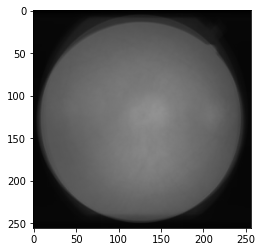

In [ ]:
# it = iter(ds1)
# k = next(it)
plt.imshow(ds1)

## Test


In [ ]:
%%capture
import rbv_gen
import models_r

In [ ]:
%%capture
reload(models_r);
reload(rbv_gen);
reload(callbacks);

In [ ]:
%cd /content
ds1, ds2 = rbv_gen.tf_dataset(center = True)

/content


100%|██████████| 9193/9193 [00:11<00:00, 800.30it/s]


In [ ]:
it = iter(ds2)

In [ ]:
k = next(it)

In [ ]:
k[0].shape

TensorShape([1, 128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


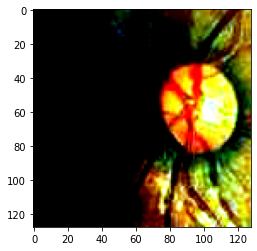

In [ ]:
plt.imshow(k[0][0])

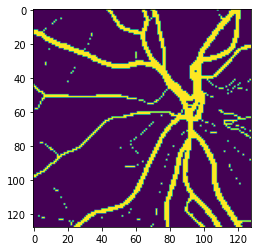

In [ ]:
plt.imshow(k[1][0])